In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import IsolationForest

In [2]:
# Load dataset
data = pd.read_csv('creditcard.csv')

In [3]:
# Data overview
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
# Data Preprocessing
# Separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

In [5]:
# Feature Scaling
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

In [6]:
# Outlier Detection and Removal using Isolation Forest (Only on Non-Fraudulent Data)
X_non_fraud = X[y == 0]
y_non_fraud = y[y == 0]

iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(X_non_fraud)
non_outlier_indices = np.where(outliers == 1)[0]

X_non_fraud = X_non_fraud.iloc[non_outlier_indices]
y_non_fraud = y_non_fraud.iloc[non_outlier_indices]

In [7]:
# Combine the filtered non-fraud data with the fraudulent data
X_fraud = X[y == 1]
y_fraud = y[y == 1]

X = pd.concat([X_non_fraud, X_fraud], axis=0)
y = pd.concat([y_non_fraud, y_fraud], axis=0)

In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Plot number of data points at each stage
stages = ['Original', 'After Outlier Removal', 'Train Split', 'After SMOTE', 'Test Split']

In [10]:
# Handling class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

counts = [
    {'Fraud': len(data[data['Class'] == 1]), 'Non-Fraud': len(data[data['Class'] == 0])},
    {'Fraud': len(y_fraud), 'Non-Fraud': len(y_non_fraud)},
    {'Fraud': len(y_train[y_train == 1]), 'Non-Fraud': len(y_train[y_train == 0])},
    {'Fraud': len(y_resampled[y_resampled == 1]), 'Non-Fraud': len(y_resampled[y_resampled == 0])},
    {'Fraud': len(y_test[y_test == 1]), 'Non-Fraud': len(y_test[y_test == 0])}
]

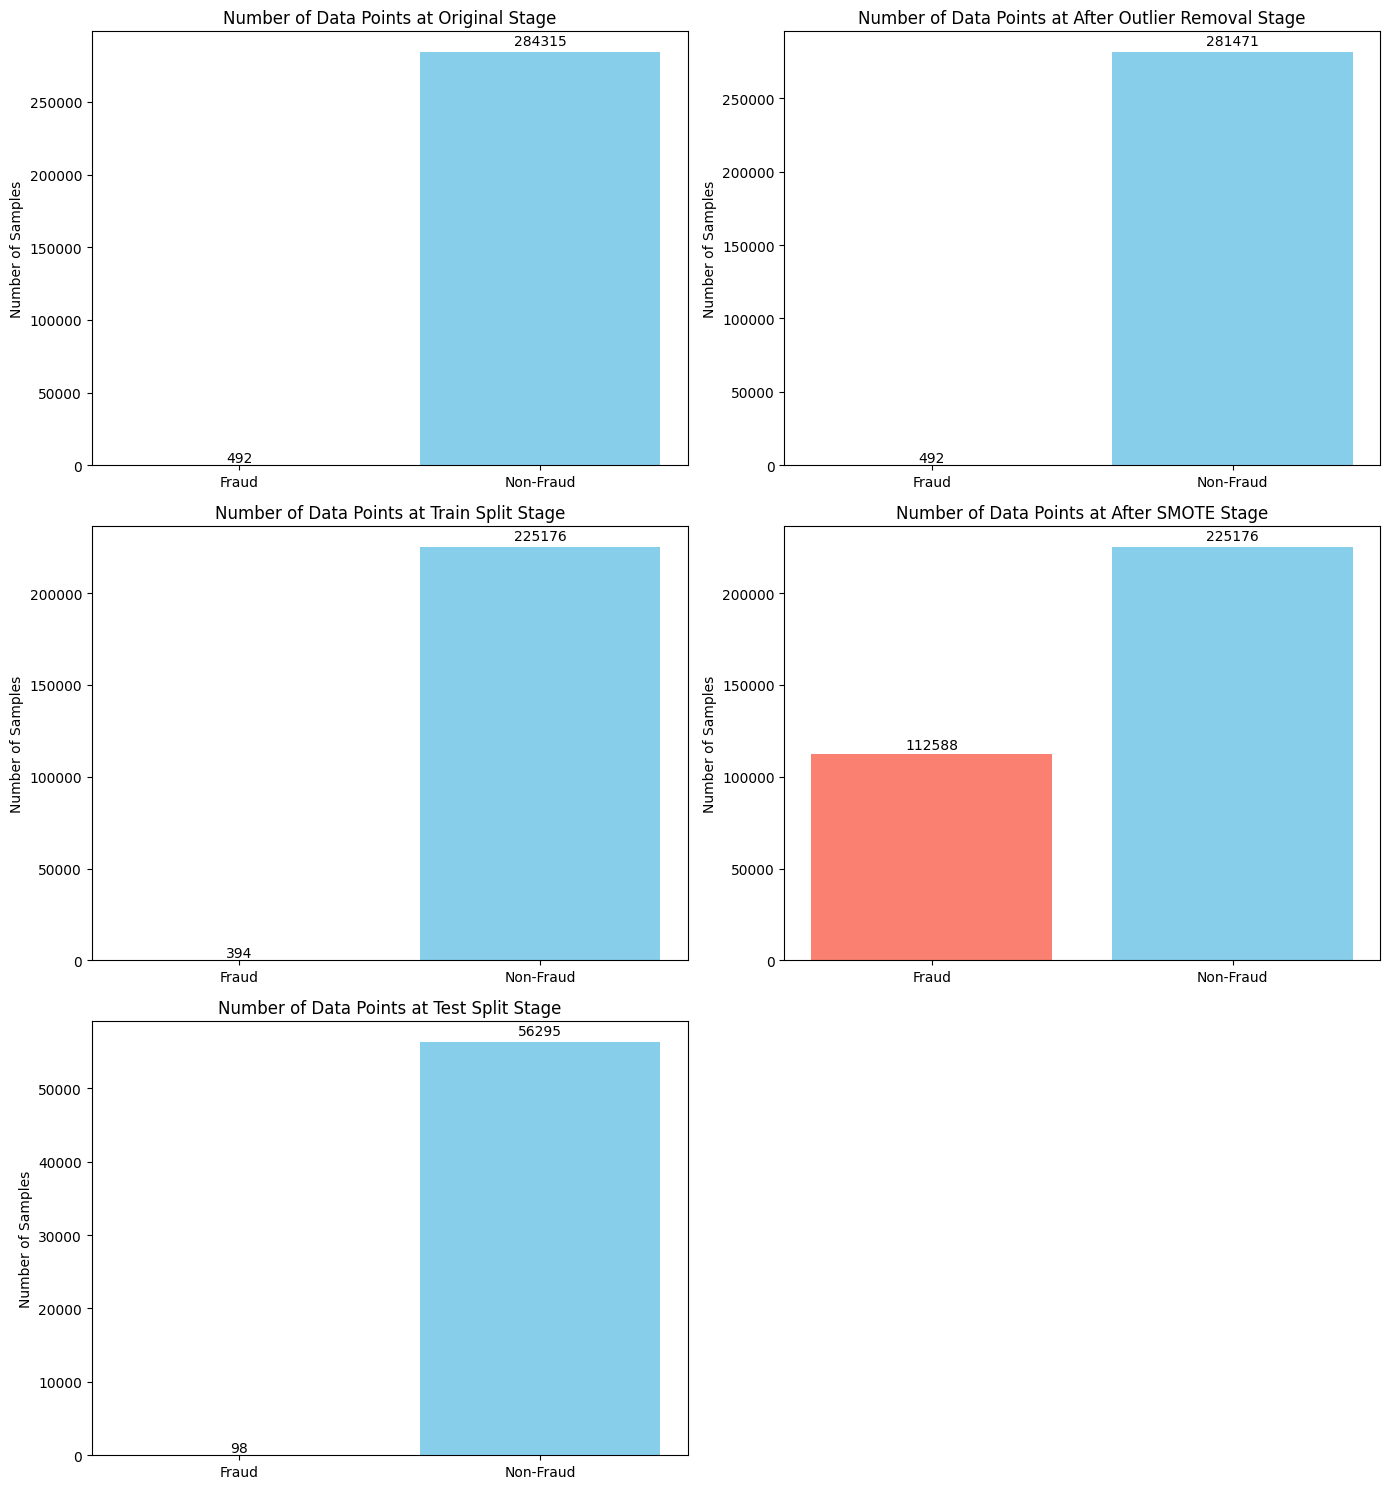

In [11]:
# Plotting data at each stage with Fraud/Non-Fraud count and displaying the counts
fig, ax = plt.subplots(3, 2, figsize=(14, 15))
fig.delaxes(ax[2, 1])  # Remove the extra subplot
stage_names = ['Original', 'After Outlier Removal', 'Train Split', 'After SMOTE', 'Test Split']
for i, stage in enumerate(stage_names):
    row, col = divmod(i, 2)
    fraud_count = counts[i]['Fraud']
    non_fraud_count = counts[i]['Non-Fraud']
    bars = ax[row, col].bar(['Fraud', 'Non-Fraud'], [fraud_count, non_fraud_count], color=['salmon', 'skyblue'])
    ax[row, col].set_title(f'Number of Data Points at {stage} Stage')
    ax[row, col].set_ylabel('Number of Samples')
    for bar, count in zip(bars, [fraud_count, non_fraud_count]):
        height = bar.get_height()
        ax[row, col].text(bar.get_x() + bar.get_width() / 2, height * 1.01, f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# Model: XGBoost with Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [10, 15, 20]
}

best_model = None
best_auprc = 0
best_params = None

In [13]:
for n_estimators in param_grid['n_estimators']:
    print(f'Testing n_estimators: {n_estimators}')
    for max_depth in param_grid['max_depth']:
        print(f'Testing max_depth: {max_depth}')
        for learning_rate in param_grid['learning_rate']:
            print(f'Testing learning_rate: {learning_rate}')
            for subsample in param_grid['subsample']:
                print(f'Testing subsample: {subsample}')
                for colsample_bytree in param_grid['colsample_bytree']:
                    print(f'Testing colsample_bytree: {colsample_bytree}')
                    for scale_pos_weight in param_grid['scale_pos_weight']:
                        print(f'Testing scale_pos_weight: {scale_pos_weight}')
                        xgb_model = xgb.XGBClassifier(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            scale_pos_weight=scale_pos_weight,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            random_state=42
                        )
                        xgb_model.fit(X_resampled, y_resampled)
                        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
                        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
                        auprc = auc(recall, precision)
                        print(f'Params: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}, scale_pos_weight={scale_pos_weight}, AUPRC: {auprc:.4f}')

                        if auprc > best_auprc:
                            best_auprc = auprc
                            best_model = xgb_model
                            best_params = {
                                'n_estimators': n_estimators,
                                'max_depth': max_depth,
                                'learning_rate': learning_rate,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'scale_pos_weight': scale_pos_weight
                            }


Testing n_estimators: 50
Testing max_depth: 3
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7171
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.6965
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.6523
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.6218
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.6494
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.6862
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.4775
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.4745
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4666
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7170
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.6968
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.6942
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.6217
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.6495
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.6883
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.4777
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.4743
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4706
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7134
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.6964
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.5474
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.5809
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.6494
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.6800
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.4775
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.4744
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4696
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8328
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8292
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8348
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8319
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8326
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8340
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8311
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8291
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8330
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8357
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8414
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8383
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8413
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8317
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8285
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8276
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8352
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8322
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8394
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8345
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8388
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8360
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8391
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8314
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8313
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8317
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8323
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8526
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8565
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8506
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8593
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8468
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8455
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8534
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8554
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8461
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8536
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8535
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8564
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8553
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8503
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8535
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8526
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8488
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8436
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8471
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8479
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8538
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8541
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8432
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8446
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8487
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8466
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8457
Testing max_depth: 5
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7984
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7986
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7958
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7988
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7923
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7946
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7634
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7594
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4983
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7959
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7911
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7984
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7965
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7898
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7956
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7635
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7588
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4965
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7983
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7945
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7989
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7988
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7941
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7955
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7614
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.6874
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.4951
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8611
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8502
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8537
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8552
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8529
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8539
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8502
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8511
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8520
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8588
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8531
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8458
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8626
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8591
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8539
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8488
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8459
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8555
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8639
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8491
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8503
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8575
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8568
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8389
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8582
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8497
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8398
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8567
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8549
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8511
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8646
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8621
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8556
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8546
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8575
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8605
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8588
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8538
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8556
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8657
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8623
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8578
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8595
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8622
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8464
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8539
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8585
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8579
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8657
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8541
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8613
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8534
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8552
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8616
Testing max_depth: 7
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8202
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8154
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8071
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8203
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8118
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8085
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7645
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7550
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7650
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8195
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8083
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8060
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8172
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8109
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8064
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7657
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7620
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7578
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8204
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8092
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8081
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8170
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8070
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8058
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7641
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7617
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7601
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8474
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8499
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8497
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8491
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8501
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8531
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8517
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8493
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8484
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8497
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8506
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8500
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8490
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8488
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8510
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8501
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8510
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8494
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8532
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8518
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8489
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8552
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8503
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8498
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8483
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8508
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8505
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8660
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8647
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8638
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8637
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8669
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8575
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8653
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8632
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8642
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8619
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8659
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8606
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8681
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8684
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8650
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8754
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8636
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8645
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8629
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8689
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8669
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8627
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8571
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8623
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8680
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8605
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=50, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8683
Testing n_estimators: 100
Testing max_depth: 3
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7960
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7946
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7828
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7938
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7934
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7810
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7603
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7600
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7582
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7497
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7887
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7863
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7953
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7907
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7602
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7597
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7606
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.6933
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7497
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7956
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7384
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.7954
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7375
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7775
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7595
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7594
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7580
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8529
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8531
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8524
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8495
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8527
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8522
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8497
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8509
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8516
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8564
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8524
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8564
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8515
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8524
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8478
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8500
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8567
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8507
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8520
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8546
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8517
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8515
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8522
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8494
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8481
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8524
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8543
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8507
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8521
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8571
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8575
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8521
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8566
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8542
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8594
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8495
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8599
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8568
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8538
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8541
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8528
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8534
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8597
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8535
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8517
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8476
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8530
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8518
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8510
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8520
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8505
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8571
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8550
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8515
Testing max_depth: 5
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7480
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7207
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8199
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8238
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8147
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7953
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8127
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7643
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.6930
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8230
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7208
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7203
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8205
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8137
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7978
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7766
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7677
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.6913
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8237
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7224
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7206
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8211
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8158
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8121
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7772
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7013
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.6931
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8665
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8667
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8610
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8644
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8641
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8634
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8608
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8610
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8582
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8615
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8639
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8600
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8660
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8691
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8610
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8607
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8619
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8657
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8658
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8632
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8589
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8637
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8695
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8603
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8641
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8610
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8643
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8625
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8614
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8559
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8701
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8631
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8622
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8572
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8589
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8663
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8657
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8610
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8605
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8674
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8642
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8647
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8669
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8708
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8584
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8610
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8566
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8586
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8676
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8620
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8663
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8600
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8641
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8653
Testing max_depth: 7
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8329
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7398
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7323
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8358
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8265
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8247
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8382
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8215
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8142
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8335
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7359
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7343
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8377
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8290
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8229
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8320
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7958
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7776
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8333
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7360
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7332
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8408
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8253
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8164
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8017
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7974
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7766
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8642
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8656
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8629
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8656
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8623
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8683
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8654
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8641
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8653
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8631
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8657
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8668
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8660
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8666
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8665
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8697
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8681
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8657
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8608
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8639
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8612
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8664
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8687
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8658
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8656
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8651
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8645
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8677
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8663
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8704
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8611
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8653
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8665
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8679
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8648
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8677
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8649
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8657
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8634
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8715
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8722
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8690
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8746
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8631
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8687
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8628
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8711
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8686
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8689
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8660
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8667
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8681
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8643
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=100, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8704
Testing n_estimators: 200
Testing max_depth: 3
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8165
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8132
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8038
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8148
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7940
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7879
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7952
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8084
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8053
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8173
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8142
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8124
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8155
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7941
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7901
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7951
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7887
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8071
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8167
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8088
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8038
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8112
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.7941
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.7921
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.7948
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.7903
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.7871
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8564
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8553
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8566
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8517
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8549
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8521
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8521
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8540
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8584
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8559
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8615
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8591
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8551
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8543
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8538
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8534
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8569
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8511
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8594
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8548
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8563
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8547
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8520
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8539
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8534
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8565
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8516
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8586
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8580
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8609
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8620
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8565
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8552
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8598
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8619
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8585
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8624
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8572
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8578
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8593
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8626
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8547
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8596
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8591
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8539
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8501
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8578
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8578
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8558
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8571
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8528
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8638
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8598
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=3, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8550
Testing max_depth: 5
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7644
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8376
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8461
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8315
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8342
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8374
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8335
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8346
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8357
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7506
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8458
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8458
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8316
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8314
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8335
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8333
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8354
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8355
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.7497
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7523
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8479
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8310
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8338
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8329
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8333
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8340
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8364
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8657
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8674
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8665
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8655
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8677
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8651
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8654
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8668
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8640
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8663
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8624
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8627
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8699
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8673
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8632
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8633
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8624
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8701
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8683
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8674
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8605
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8624
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8667
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8627
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8662
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8651
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8687
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8614
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8672
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8611
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8660
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8669
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8642
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8626
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8666
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8673
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8670
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8673
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8629
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8705
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8626
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8663
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8692
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8708
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8629
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8664
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8632
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8635
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8680
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8633
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8659
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8616
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8677
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=5, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8686
Testing max_depth: 7
Testing learning_rate: 0.01
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8416
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7600
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7581
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8430
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8420
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8424
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8402
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8392
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8403
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8532
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7595
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7589
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8431
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8429
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8404
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8398
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8321
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8309
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8477
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.7600
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.7581
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8469
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8414
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8392
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8394
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8309
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.01, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8310
Testing learning_rate: 0.1
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8651
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8671
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8666
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8697
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8628
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8716
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8674
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8683
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8679
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8683
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8683
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8703
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8692
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8686
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8692
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8678
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8691
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8678
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8682
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8653
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8639
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8705
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8707
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8692
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8670
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8679
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8698
Testing learning_rate: 0.2
Testing subsample: 0.8
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8704
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8692
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8723
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8648
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8707
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8703
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8720
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8668
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.8, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8709
Testing subsample: 0.9
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8706
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8713
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8660
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8725
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8727
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8708
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8732
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8718
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=0.9, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8714
Testing subsample: 1.0
Testing colsample_bytree: 0.8
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=10, AUPRC: 0.8655
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=15, AUPRC: 0.8750
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.8, scale_pos_weight=20, AUPRC: 0.8708
Testing colsample_bytree: 0.9
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=10, AUPRC: 0.8711
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=15, AUPRC: 0.8699
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=0.9, scale_pos_weight=20, AUPRC: 0.8703
Testing colsample_bytree: 1.0
Testing scale_pos_weight: 10


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=10, AUPRC: 0.8714
Testing scale_pos_weight: 15


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=15, AUPRC: 0.8716
Testing scale_pos_weight: 20


C:\Users\UNLIMITED\anaconda3\envs\Credit-Card-Fraud-Detection-Using-XGBoost\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: n_estimators=200, max_depth=7, learning_rate=0.2, subsample=1.0, colsample_bytree=1.0, scale_pos_weight=20, AUPRC: 0.8719


In [14]:
print(f"Best Parameters: {best_params}")
print(f"Best AUPRC: {best_auprc:.4f}")

Best Parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9, 'colsample_bytree': 1.0, 'scale_pos_weight': 10}
Best AUPRC: 0.8754


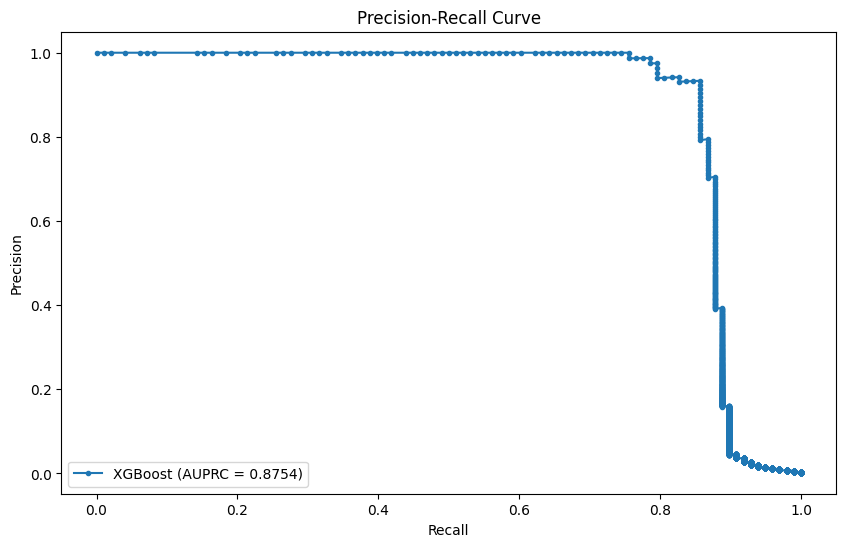

In [15]:
# Plot Precision-Recall Curve for the Best Model
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='XGBoost (AUPRC = %0.4f)' % best_auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [16]:
# Final Classification Report
y_pred = best_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56295
           1       0.36      0.89      0.51        98

    accuracy                           1.00     56393
   macro avg       0.68      0.94      0.76     56393
weighted avg       1.00      1.00      1.00     56393

